In [3]:
from scipy.integrate import odeint
import scipy.optimize as opt
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import epiecoevo_functions as eee
import importlib
import seaborn as sns
from sympy import symbols, Matrix, solve, lambdify
importlib.reload(eee)

plt.rcParams['font.sans-serif'] = "Arial"

# Analyzing the anatomy of recovery trajectories using an epi-eco-evo model

The analyses in this notebook reproduce the analyses given the the manuscript "Towards a theory of host recovery dynamics following disease-induced declines: an epi-eco-evo perspective" that is submitted for publication at the American Naturalist

## Figure 1: Make a conceptual recovery curve

In [3]:
# Set initial parameter values
params = {'r': 1, 'delta': 0.1, 'mu': 0.05, 'beta': 0.1, 'lam': 1000, 'mu_z': 100,
          'init_alpha': 2, 'alpha': 2}

# Set up all the parameters
init_k = 3
init_alpha = 2
init_v = (init_alpha**2 / init_k) + init_alpha**2
N_init = (params['r'] - params['mu']) / params['delta']
time = np.linspace(0, 30, num=2500)

init_vals = np.array([N_init, N_init*0.001, 0, init_alpha, init_v])

res = pd.DataFrame(odeint(eee.tolerance_model_no_tradeoff_approximation, init_vals, time, (params,)),
                   columns=['N', "I", 'Z', "alpha", "v"]).assign(time=time, variance=lambda x: x.v - x.alpha**2)

# Recovery indices
recov = eee.recovery_metrics(res.N.values, res.time.values, percent=0.12)

# Set-up a new simulation that starts at the minimum
N_start = res.N.values[time == recov[1]][0]
init_vals2 = np.array([N_start, 0, 0, init_alpha, init_v])
res2 = pd.DataFrame(odeint(eee.tolerance_model_no_tradeoff_approximation, init_vals2, time, (params,)),
                   columns=['N', "I", 'Z', "alpha", "v"]).assign(time=time)
#?eee.recovery_metrics

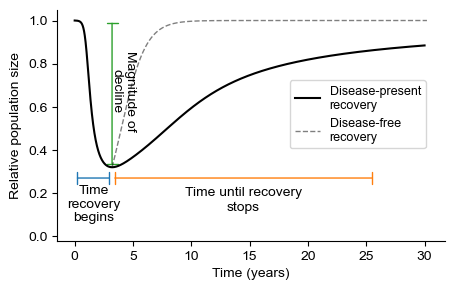

In [93]:
from matplotlib.patches import FancyArrowPatch, ArrowStyle
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(res.time, res.N / res.N[0], label="Disease-present\nrecovery", color='black')
#ax.plot(res.time, res.I / res.N, alpha=0.2, label="Prevalence")
ax.plot(res2.time.values[:-250] + recov[1], res2.N.values[:-250] / res.N[0], label="Disease-free\nrecovery", linestyle='--', color='black', lw=1, alpha=0.5)
ax.set_ylim(-0.02, 1.05)

# Recovery indices
recov = eee.recovery_metrics(res.N.values, res.time.values, percent=0.12)

y = 0.05
arrow1 = FancyArrowPatch(posA=(0, 1 - recov[0] - y), posB=(recov[1], 1 - recov[0] - y), 
                         arrowstyle=ArrowStyle("|-|", widthA=4.0, angleA=0, widthB=4.0, angleB=0),
                         color=sns.color_palette()[0])
arrow2 = FancyArrowPatch(posA=(recov[1], 1 - recov[0] - y), posB=(recov[2], 1 - recov[0] - y), 
                         arrowstyle=ArrowStyle("|-|", widthA=4.0, angleA=0, widthB=4.0, angleB=0),
                         color=sns.color_palette()[1])
arrow3 = FancyArrowPatch(posA=(recov[1], 1), posB=(recov[1], 1 - recov[0]), 
                         arrowstyle=ArrowStyle("|-|", widthA=4.0, angleA=0, widthB=4.0, angleB=0),
                         color=sns.color_palette()[2], linewidth=1)

ax.add_patch(arrow1)
ax.add_patch(arrow2)
ax.add_patch(arrow3)

ax.set_ylabel("Relative population size")
ax.set_xlabel("Time (years)")
ax.text(recov[2] / 2 + recov[1] / 2, 1 - recov[0] - 0.2, "Time until recovery\nstops", ha="center")
ax.text(recov[1] / 2, 1 - recov[0] - 0.25, "Time\nrecovery\nbegins", ha="center")
ax.text(recov[1] + 1, 0.5, "Magnitude of\ndecline", ha="center", rotation=-90)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc=(0.6, 0.4), prop={'size': 9}, frameon=True)
#ax.set_title("Single species population")
fig.savefig("../results/conceptual_recovery.pdf", bbox_inches="tight")
#ax.arrow(0, 1 - recov[0], recov[1], 0)

# Question 1: How does host life history strategy, parasite life history strategy and initial variability in host defense affect the recovery trajectories of a host population?

The results below use the moment-closure models for resistance and tolerance. For the equivalent results from the full models, see `pcc_full_model_comparison.py` 

## Resistance

In [437]:
from scipy.stats import qmc
import scipy.stats as stats
importlib.reload(eee)

# Set-up a latin hypercube simulation
samps = 1000
percent = 0.02 # Recovery threshold
plist = ['init_beta', 'lam', 'mu_z', 'r', 'mu', 'init_k', 'alpha', 'delta']
lower = [0.05, 100,  10,    0.1, 0.1, 0.5,  1, 0.1]
upper = [0.3,  1000, 100,   10,  3,    5,   3, 0.5]
sampler = qmc.LatinHypercube(d=len(lower))
sample = sampler.random(samps)
lhc_params = qmc.scale(sample, lower, upper)

# Predictors
parasiter_vals = []
parasiteR0_vals = []
hostr_vals = []
initial_cv = []
delta_vals = []

# Output
time_decline_stop = []
time_full_recovery = []
time_full_recovery_no_pathogen = []
magnitude_of_decline = []
inds_used = []
trajectories = []
params_used = []
check_convergence = []

for s in range(samps):
    
    # Set parameters for simulation
    params = {}
    params['beta_m'] = 0.0
    for i, p in enumerate(plist):
        params[p] = lhc_params[s, i]
    params['beta'] = params['init_beta']
    
    # Set up initial values
    init_k = params['init_k']
    init_beta = params['init_beta']
    init_v = (init_beta**2 / init_k) + init_beta**2
    init_var = init_v - init_beta**2

    N_init = (params['r'] - params['mu']) / params['delta']
    parasiteR0 = (N_init*params['init_beta']*params['lam']) / ((params['alpha'] + params['mu'])*params['mu_z'])#max_eig(N_init, params)
    hostr = params['r'] - params['mu']

    if parasiteR0 > 1 and hostr > 0:
        parasiter = eee.max_eig(N_init, params)
        
        # Account for boundary conditions
        if parasiter > 0.01:

            time = np.linspace(0, 5000, num=50000)
            init_vals = np.array([N_init, N_init*0.001, 0, init_beta, init_beta, init_v, init_v])

            res, out = odeint(eee.resistance_model_tradeoff, init_vals, time, (params,), full_output=True)
            res = pd.DataFrame(res, columns=['N', "I", "Z", "betaN", "betaI", "vN", "vI"]).assign(time=time)
            check_convergence.append(out['message'] == "Integration successful.")

            # Get recovery metrics
            recov = eee.recovery_metrics(res.N.values, time, percent=percent, change_point=False)
            
            # Simulate a disease free model from where the decline stops
            N_start = res.N.values[time == recov[1]][0]
            init_vals2 = np.array([N_start, 0, 0])
            res2 = pd.DataFrame(odeint(eee.moment_closure_model_single_spp_no_evo, init_vals2, time, (params,)),
                                columns=['N', "I", "Z"]).assign(time=time)
            
            # Extract the time until recovery for a disease-free population
            if recov[0] > percent:
                df_recov = res2.time.values[np.where(res2.N.values < res.N.values[0]*(1 - percent))[0][-1]]
            else:
                df_recov = recov[2]
            
            # Save results
            time_full_recovery_no_pathogen.append(df_recov)
            magnitude_of_decline.append(recov[0])
            time_decline_stop.append(recov[1])
            time_full_recovery.append(recov[2])
            inds_used.append(s)
            parasiter_vals.append(parasiter)
            parasiteR0_vals.append(parasiteR0)
            hostr_vals.append(hostr)
            delta_vals.append(params['delta'])
            initial_cv.append(np.sqrt(init_var) / init_beta)
            trajectories.append(res)
            params_used.append(params)

# convert to arrays
magnitude_of_decline = np.array(magnitude_of_decline)
time_decline_stop = np.array(time_decline_stop)
time_full_recovery = np.array(time_full_recovery)
time_full_recovery_no_pathogen = np.array(time_full_recovery_no_pathogen)
inds_used = np.array(inds_used)
parasiter_vals = np.array(parasiter_vals)
parasiteR0_vals = np.array(parasiteR0_vals)
hostr_vals = np.array(hostr_vals)
initial_cv = np.array(initial_cv)
check_convergence = np.array(check_convergence)

In [3]:
# How many with poor integration?
np.sum(~check_convergence)

5

### Figure 2: Make the resistance results for Figure 2

/Users/mqwilber/opt/anaconda3/envs/recovery/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Text(0, 0.5, 'Partial Correlation Coefficient')

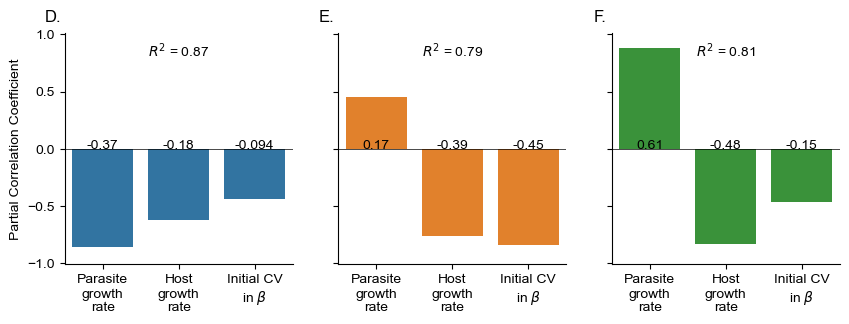

In [438]:
from statsmodels.api import GLM
from patsy import dmatrix, dmatrices
from pingouin import partial_corr
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

output = [time_decline_stop, time_full_recovery, magnitude_of_decline]
ylabels = ["Time until recovery starts", "Time until recovery stops", "Magnitude of decline"]
letters = ['D.' ,'E.', 'F.']

# Use these conditions to eliminate boundary conditions and simulation 
# problems
cond = (pd.Series(time_decline_stop <= 0.3) |
        pd.Series(parasiter_vals <= 10**-0.5) |
        pd.Series(parasiteR0_vals > 20) |
        pd.Series(magnitude_of_decline < percent) |
        pd.Series(time_full_recovery).isna() |
        pd.Series(check_convergence == False)).values
which_inds = np.where(cond)[0]
good_inds = np.where(~cond)[0] # Inds that have some decline

fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
axes = axes.ravel()

for i, out in enumerate(output):
    
    dat = pd.DataFrame({'x1': np.log(parasiter_vals[good_inds]), 
                        'x2': np.log(hostr_vals[good_inds]),
                        'x3': np.log(initial_cv[good_inds]),
                        'y': np.log(out[good_inds])})
    xnames = {'x1': "Parasite\ngrowth\nrate", 
              'x2': "Host\ngrowth\nrate",
              'x3': "Initial CV\n" + r"in $\beta$"}
    xnm = list(xnames.keys())
    
    y, fullX = dmatrices("y ~ scale(x1) + scale(x2) + scale(x3)", data=dat, return_type="dataframe")
    fullfit = GLM(y, fullX).fit()
    fullresid = fullfit.resid_pearson
    R2 = 1 - (np.sum(fullresid**2) / np.sum((y.values - np.mean(y.values))**2))
    coefs = fullfit.params[1:]
    
    pcorr_all = {}
    for x in xnm:
        newx = list(xnames.keys())
        newx.remove(x)
        pcorr = partial_corr(data=dat, x=x, y="y", covar=newx, method="pearson")
        pcorr_all[xnames[x]] = [pcorr.r.values[0]]
    
    sns.barplot(pd.DataFrame(pcorr_all), ax=axes[i], palette=np.repeat(sns.color_palette().as_hex()[i], 3))
    xlim = axes[i].get_xlim()
    axes[i].hlines(0, *xlim, color='black', linewidth=0.5)
    axes[i].set_xlim(*xlim)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    #axes[i].set_title(ylabels[i])
    axes[i].text(-0.05, 1.05, letters[i], size=12, ha='center', transform=axes[i].transAxes)
    axes[i].text(0.5, 0.9, "$R^2$ = {0:.2}".format(R2), ha='center', transform=axes[i].transAxes)
    axes[i].set_ylim(-1.01, 1.01)
    xticks = axes[i].get_xticks()
    for t, cf in enumerate(coefs):
        axes[i].text(xticks[t], 0, "{0:.2}".format(cf), ha='center')

axes[0].set_ylabel("Partial Correlation Coefficient")
#fig.savefig("../results/pcc_basemodel_resistance.pdf", bbox_inches="tight")

In [ ]:
# Compare recovery time for resistance hosts
recov_time_compare_resistance = time_full_recovery[good_inds] / time_full_recovery_no_pathogen[good_inds]

## Make partial correlation plots for visualization

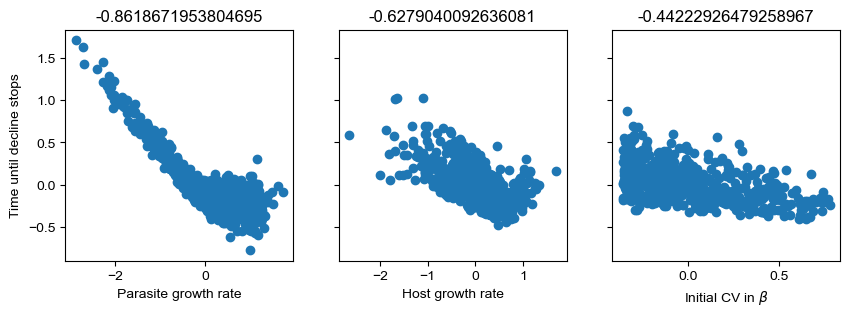

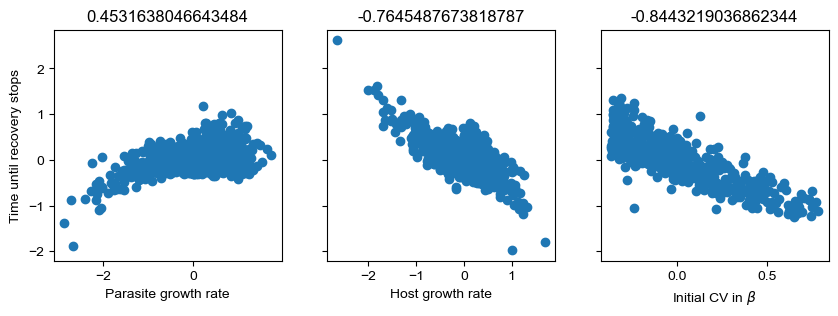

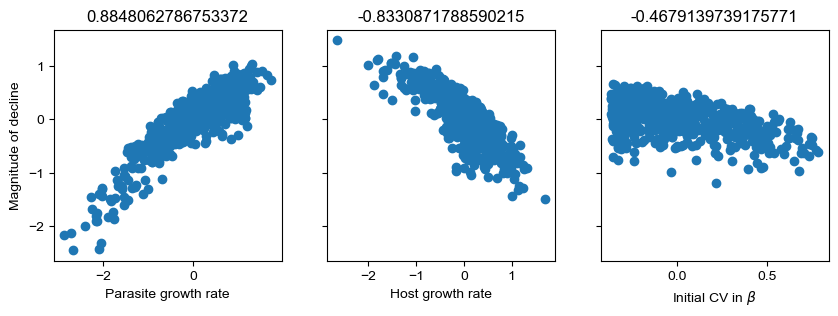

In [439]:
from statsmodels.api import GLM
from patsy import dmatrix, dmatrices
from pingouin import partial_corr

output = [time_decline_stop, time_full_recovery, magnitude_of_decline]
ylabels = ["Time until decline stops", "Time until recovery stops", "Magnitude of decline"]

cond = (pd.Series(time_decline_stop <= 0.3) | 
        pd.Series(parasiter_vals <= 10**-0.5) |
        pd.Series(parasiteR0_vals > 20) |
        pd.Series(magnitude_of_decline < percent) | 
        pd.Series(check_convergence == False)).values
which_inds = np.where(cond)[0]
good_inds = np.where(~cond)[0] # Inds that have some decline

# fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
# axes = axes.ravel()

for i, out in enumerate(output):
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
    axes = axes.ravel()
    
    dat = pd.DataFrame({'pr': np.log(parasiter_vals[good_inds]),
                        'hr': np.log(hostr_vals[good_inds]),
                        'cv': np.log(initial_cv[good_inds]),
                        'out': np.log(out[good_inds])})
    
    y1, X1 = dmatrices("out ~ hr + cv", data=dat, return_type="dataframe")
    y2, X2 =  dmatrices("pr ~ hr + cv", data=dat, return_type="dataframe")
    resid1 = GLM(y1, X1).fit().resid_pearson
    resid2 = GLM(y2, X2).fit().resid_pearson
    axes[0].plot(resid2, resid1, 'o')
    axes[0].set_title(np.corrcoef(resid2, resid1)[0, 1])
    axes[0].set_xlabel("Parasite growth rate")
    axes[0].set_ylabel(ylabels[i])

    y1, X1 = dmatrices("out ~ pr + cv", data=dat, return_type="dataframe")
    y2, X2 =  dmatrices("hr ~ pr + cv", data=dat, return_type="dataframe")
    resid1 = GLM(y1, X1).fit().resid_pearson
    resid2 = GLM(y2, X2).fit().resid_pearson
    axes[1].plot(resid2, resid1, 'o')
    axes[1].set_title(np.corrcoef(resid2, resid1)[0, 1])
    axes[1].set_xlabel("Host growth rate")
    
    y1, X1 = dmatrices("out ~ hr + pr", data=dat, return_type="dataframe")
    y2, X2 =  dmatrices("cv ~ hr + pr", data=dat, return_type="dataframe")
    resid1 = GLM(y1, X1).fit().resid_pearson
    resid2 = GLM(y2, X2).fit().resid_pearson
    axes[2].plot(resid2, resid1, 'o')
    axes[2].set_title(np.corrcoef(resid2, resid1)[0, 1])
    axes[2].set_xlabel(r"Initial CV in $\beta$")

11.233128001407486
6.018866304842528
9.865300269826003
4.617030749899207
15.485381605375878
6.431392279496263
5.271783567223835
5.42035462999642
7.551192407151195
1.3983563843298557
15.604100756516956
5.636747267574856
0.929051855588817
1.8105295845401763
16.927147228970846
6.168090870878422
16.927147228970846
6.168090870878422
7.901792284716201
1.2200529227228984
15.57040303474264
8.059455030329492


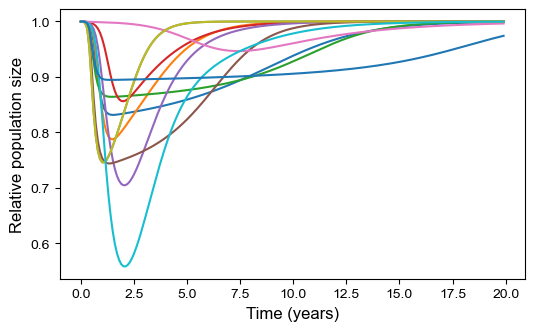

In [142]:
# Plot some example trajectories
np.random.seed(120)
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
rand_inds = np.random.choice(np.arange(len(trajectories)), size=20)
for r in rand_inds:
    
    if parasiteR0_vals[r] < 10:
        tres = trajectories[r]
        tind = tres.time < 20
        #ax.plot(tres.time[tind], tres.I[tind] / tres.N[tind])
        ax.plot(tres.time[tind], tres.N[tind] / tres.N[0])
        #ax.plot(tres.time[tind], tres.betaI[tind] / tres.betaI[0])
        #ax.plot(tres.time[tind], tres.betaN[tind] / tres.betaN[0])
        print(parasiter_vals[r])
        print(hostr_vals[r])
ax.set_xlabel("Time (years)", size=12)
ax.set_ylabel("Relative population size", size=12)

## Figure 4: Plot bifurcation diagrams of resistance strategies

In [243]:
def add_arrow(line, position=None, direction='right', size=15, color=None, score=50):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = stats.scoreatpercentile(xdata, score) #xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="-|>", color=color),
        size=size
    )

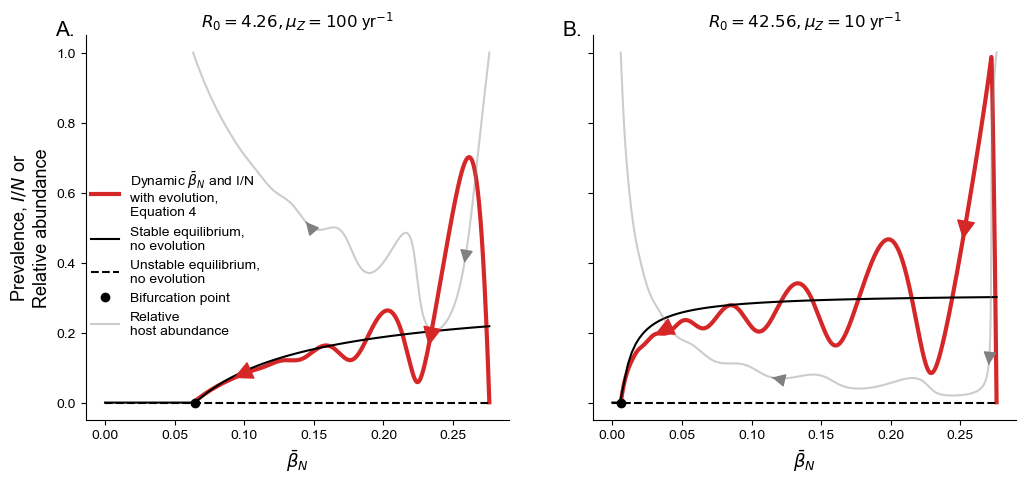

In [310]:
params = {'alpha_m': 0,
         'lam': 800,
         'mu_z': 100,
         'r': 1.68,
         'mu': 0.56,
         'init_k': 10,
         'alpha': 3.59,
         'delta': 0.14,
         'beta': 0.276,
         'beta_m': 0.0}

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axes = axes.ravel()

mu_z_vals = [100, 10]
legend_loc = [(0, 0.2), (0.5, 0.7)]
letters = ['A.', 'B.']

for i in range(len(mu_z_vals)):

    # Set up initial values
    init_k = params['init_k']
    init_beta = params['beta']
    init_v = (init_beta**2 / init_k) + init_beta**2
    init_var = init_v - init_beta**2
    params['mu_z'] = mu_z_vals[i]

    N_init = (params['r'] - params['mu']) / params['delta']
    parasiteR0 = (N_init*params['beta']*params['lam']) / ((params['alpha'] + params['mu'])*params['mu_z'])#max_eig(N_init, params)
    hostr = params['r'] - params['mu']

    time = np.linspace(0, 100, num=10000)
    init_vals = np.array([N_init, N_init*0.001, 0, init_beta, init_beta, init_v, init_v])

    res = pd.DataFrame(odeint(eee.resistance_model_tradeoff, init_vals, time, (params,)),
                       columns=['N', "I", "Z", "betaN", "betaI", "vN", "vI"]).assign(time=time)

    beta_values = np.linspace(0, res.betaN.max(), num=100)
    equil_prev = []
    for beta in beta_values:
        params['beta'] = beta
        R0 = (N_init*params['beta']*params['lam']) / ((params['alpha'] + params['mu'])*params['mu_z'])
        if R0 < 1:
            equil_prev.append(0)
        else:
            equil = opt.fsolve(eee.moment_closure_model_single_no_evo_equil, 
                   [N_init, (1 - (1 / R0))*N_init, (1 - (1 / R0))*N_init*(params['lam'] / params['mu_z'])],
                   (params, ))
            equil_prev.append(equil[1] / equil[0])

    R0_vals = (N_init*res.betaN*params['lam']) / ((params['alpha'] + params['mu'])*params['mu_z'])

    line = axes[i].plot(res.betaN, res.I / res.N, lw=3, color=sns.color_palette()[3], 
                        label=r"Dynamic $\bar{\beta}_N$"+ " and I/N" + "\nwith evolution,\nEquation 4")[0]
    axes[i].plot(beta_values, equil_prev, color='black', label="Stable equilibrium,\nno evolution")
    axes[i].plot(beta_values, np.repeat(0, len(beta_values)), color='black', ls='--', label="Unstable equilibrium,\nno evolution")
    #ax2 = ax.twinx()

    axes[i].set_xlabel(r"$\bar{\beta}_N$", size=13)
    #ax2.set_ylabel("Relative abundance", size=15)

    beta_bif = ((params['alpha'] + params['mu'])*params['mu_z']) / (N_init * params['lam'])
    axes[i].plot([beta_bif], [0], 'o', color='black', label="Bifurcation point")

    line2 = axes[i].plot(res.betaN, res.N / res.N[0], color='gray', alpha=0.4, label="Relative\nhost abundance")[0]
    
    if i == 0:
        axes[i].legend(loc=legend_loc[i], frameon=False)
        axes[i].set_ylabel(r"Prevalence, $I / N$ or" + "\nRelative abundance", size=13)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)

    # Draw arrow
    add_arrow(line, direction="right", size=30, score=80)
    add_arrow(line, direction="right", size=30, score=98)
    add_arrow(line2, direction="right", size=20, score=99)
    add_arrow(line2, direction="right", size=20, score=90)
    
    axes[i].set_title(r"$R_0 = {0:.2f}, \mu_Z = {1}$".format(parasiteR0, params['mu_z']) + " yr$^{-1}$")
    axes[i].text(-0.05, 1, letters[i], size=15, ha='center', transform=axes[i].transAxes)
    
fig.savefig("../results/bifurcation_plots.pdf", bbox_inches="tight")

## Tolerance analysis

In [440]:
from scipy.stats import qmc
import scipy.stats as stats
importlib.reload(eee)

# Set-up a latin hypercube simulation
samps = 5000
percent = 0.02
plist = ['beta', 'lam', 'mu_z', 'r', 'mu', 'init_k', 'init_alpha', 'delta']
lower = [0.05, 100,  10,    0.1, 0.1, 0.5,  1, 0.1]
upper = [0.3,  1000, 100,   10,  3,    5,   3, 0.5]
sampler = qmc.LatinHypercube(d=len(lower))
sample = sampler.random(samps)
lhc_params = qmc.scale(sample, lower, upper)

# Predictors
parasiter_vals = []
parasiteR0_vals = []
hostr_vals = []
initial_cv = []
delta_vals = []

# Output
time_decline_stop = []
time_full_recovery = []
magnitude_of_decline = []
inds_used = []
trajectories = []
time_full_recovery_no_pathogen = []

for s in range(samps):
    
    # Set parameters for simulation
    params = {}
    #params['delta'] = 0.1
    for i, p in enumerate(plist):
        params[p] = lhc_params[s, i]
    params['alpha'] = params['init_alpha']
    
    # Set up initial values
    init_k = params['init_k']
    init_alpha = params['init_alpha']
    init_v = (init_alpha**2 / init_k) + init_alpha**2
    init_var = init_v - init_alpha**2 # init_alpha**2 / init_k #

    N_init = (params['r'] - params['mu']) / params['delta']
    parasiteR0 = (N_init*params['beta']*params['lam']) / ((params['init_alpha'] + params['mu'])*params['mu_z'])#max_eig(N_init, params)
    hostr = params['r'] - params['mu']

    if parasiteR0 > 1 and hostr > 0:
        parasiter = eee.max_eig(N_init, params)
        
        if parasiter > 0.01:

            time = np.linspace(0, 5000, num=25000)
            init_vals = np.array([N_init, N_init*0.001, 0, init_alpha, init_v])

            res = pd.DataFrame(odeint(eee.tolerance_model_no_tradeoff_approximation, init_vals, time, (params,)),
                               columns=['N', "I", 'Z', "alpha", "v"]).assign(time=time)

            # Save results
            recov = eee.recovery_metrics(res.N.values, time, percent=percent)
            
            # Simulate a disease free model from where the decline stops
            N_start = res.N.values[time == recov[1]][0]
            init_vals2 = np.array([N_start, 0, 0])
            res2 = pd.DataFrame(odeint(eee.moment_closure_model_single_spp_no_evo, init_vals2, time, (params,)),
                                columns=['N', "I", "Z"]).assign(time=time)
            
            # Extract the time until recovery for a disease-free population
            if recov[0] > percent:
                df_recov = res2.time.values[np.where(res2.N.values < res.N.values[0]*(1 - percent))[0][-1]]
            else:
                df_recov = recov[2]
            
            
            magnitude_of_decline.append(recov[0])
            time_decline_stop.append(recov[1])
            time_full_recovery.append(recov[2])
            time_full_recovery_no_pathogen.append(df_recov)
            inds_used.append(s)
            parasiter_vals.append(parasiter)
            parasiteR0_vals.append(parasiteR0)
            hostr_vals.append(hostr)
            delta_vals.append(params['delta'])
            initial_cv.append(np.sqrt(init_var) / init_alpha)
            trajectories.append(res)

# convert to arrays
magnitude_of_decline = np.array(magnitude_of_decline)
time_decline_stop = np.array(time_decline_stop)
time_full_recovery = np.array(time_full_recovery)
inds_used = np.array(inds_used)
parasiter_vals = np.array(parasiter_vals)
parasiteR0_vals = np.array(parasiteR0_vals)
hostr_vals = np.array(hostr_vals)
initial_cv = np.array(initial_cv)
time_full_recovery_no_pathogen = np.array(time_full_recovery_no_pathogen)

In [441]:
stats.scoreatpercentile(parasiteR0_vals[parasiteR0_vals < 20], (25, 50, 75))

array([ 2.74715431,  5.52344833, 10.01481516])

In [442]:
len(parasiteR0_vals[parasiteR0_vals < 20])

2959

### Figure 2: Make the tolerance results for Figure 2 

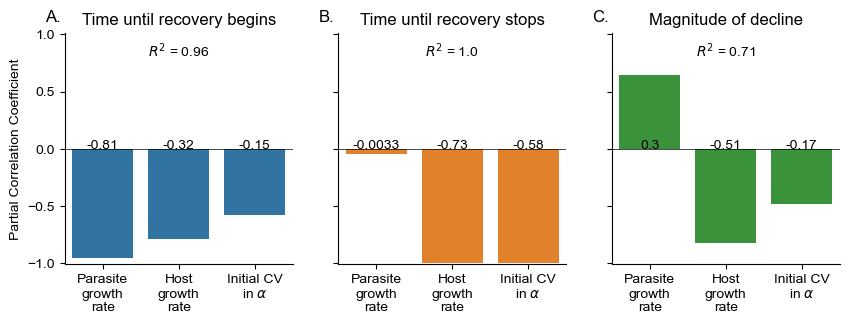

In [8]:
from statsmodels.api import GLM
from patsy import dmatrix, dmatrices
from pingouin import partial_corr
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

output = [time_decline_stop, time_full_recovery, magnitude_of_decline]
ylabels = ["Time until recovery begins", "Time until recovery stops", "Magnitude of decline"]
letters =['A.', "B.", 'C.']

cond = (pd.Series(time_decline_stop <= 0.3) |
        pd.Series(parasiter_vals <= 10**-0.5) |
        pd.Series(magnitude_of_decline < percent) | 
        pd.Series(parasiteR0_vals) > 20).values
which_inds = np.where(cond)[0]
good_inds = np.where(~cond)[0] # Inds that have some decline

fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
axes = axes.ravel()

for i, out in enumerate(output):
    
    dat = pd.DataFrame({'x1': np.log(parasiter_vals[good_inds]), 
                        'x2': np.log(hostr_vals[good_inds]),
                        'x3': np.log(initial_cv[good_inds]),
                        'y': np.log(out[good_inds] + 0.001)})
    xnames = {'x1': "Parasite\ngrowth\nrate", 
              'x2': "Host\ngrowth\nrate",
              'x3': "Initial CV\n" +  r"in $\alpha$"}
    xnm = list(xnames.keys())
    
    y, fullX = dmatrices("y ~ scale(x1) + scale(x2) + scale(x3)", data=dat, return_type="dataframe")
    fullfit = GLM(y, fullX).fit()
    fullresid = fullfit.resid_pearson
    R2 = 1 - (np.sum(fullresid**2) / np.sum((y.values - np.mean(y.values))**2))
    coefs = fullfit.params[1:]
    
    pcorr_all = {}
    for x in xnm:
        newx = list(xnames.keys())
        newx.remove(x)
        pcorr = partial_corr(data=dat, x=x, y="y", covar=newx, method="pearson")
        pcorr_all[xnames[x]] = [pcorr.r.values[0]]
    
    sns.barplot(pd.DataFrame(pcorr_all), ax=axes[i], palette=np.repeat(sns.color_palette().as_hex()[i], 3))
    xlim = axes[i].get_xlim()
    axes[i].hlines(0, *xlim, color='black', linewidth=0.5)
    axes[i].set_xlim(*xlim)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    axes[i].set_title(ylabels[i])
    axes[i].text(-0.05, 1.05, letters[i], size=12, ha='center', transform=axes[i].transAxes)
    axes[i].text(0.5, 0.9, "$R^2$ = {0:.2}".format(R2), ha='center', transform=axes[i].transAxes)
    xticks = axes[i].get_xticks()
    axes[i].set_ylim(-1.01, 1.01)
    for t, cf in enumerate(coefs):
        axes[i].text(xticks[t], 0, "{0:.2}".format(cf), ha='center')

axes[0].set_ylabel("Partial Correlation Coefficient")
fig.savefig("../results/pcc_basemodel.pdf", bbox_inches="tight")

### Visualize the partial correlation plots

/Users/mqwilber/opt/anaconda3/envs/recovery/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


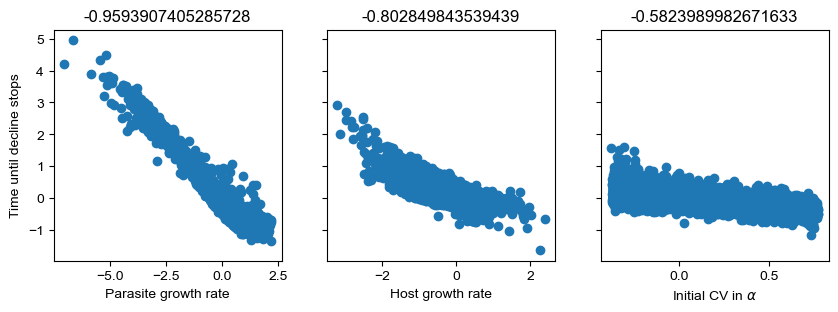

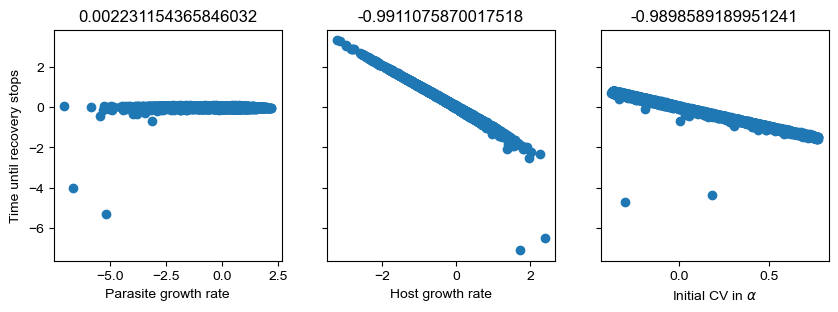

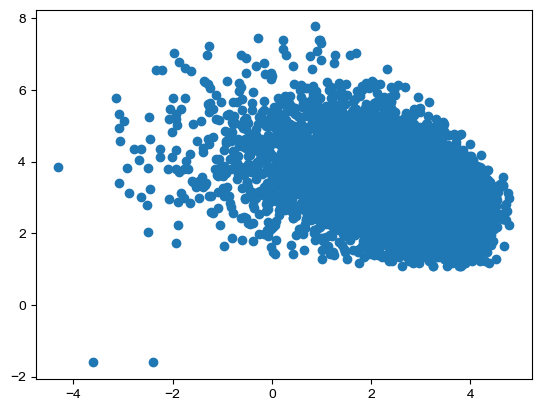

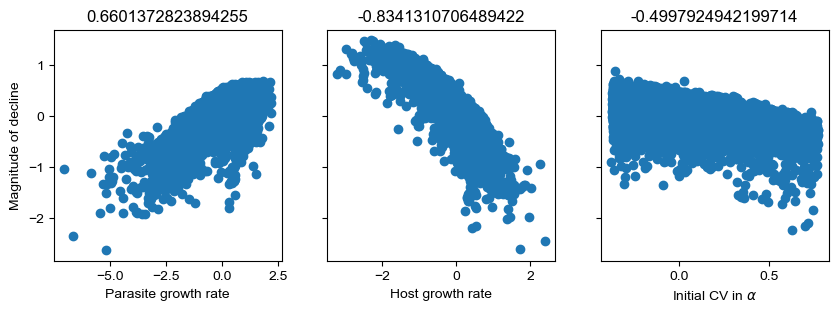

In [5]:
from statsmodels.api import GLM
from patsy import dmatrix, dmatrices
from pingouin import partial_corr

output = [time_decline_stop, time_full_recovery, magnitude_of_decline]
ylabels = ["Time until decline stops", "Time until recovery stops", "Magnitude of decline"]

cond = (pd.Series(time_decline_stop <= 0.3) | 
        pd.Series(parasiter_vals <= 10**-0.5) |
        pd.Series(magnitude_of_decline < percent) | 
        pd.Series(parasiteR0_vals) > 20).values
which_inds = np.where(cond)[0]
good_inds = np.where(~cond)[0] # Inds that have some decline

# fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
# axes = axes.ravel()

for i, out in enumerate(output):
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
    axes = axes.ravel()
    
    dat = pd.DataFrame({'pr': np.log(parasiter_vals[good_inds]),
                        'hr': np.log(hostr_vals[good_inds]),
                        'cv': np.log(initial_cv[good_inds]),
                        'out': np.log(out[good_inds] + 0.001)})
    
    if i == 1:
        tfig, tax = plt.subplots(1, 1)
        tax.plot(dat.pr, dat.out, 'o')
    
    y1, X1 = dmatrices("out ~ hr + cv", data=dat, return_type="dataframe")
    y2, X2 =  dmatrices("pr ~ hr + cv", data=dat, return_type="dataframe")
    resid1 = GLM(y1, X1).fit().resid_pearson
    resid2 = GLM(y2, X2).fit().resid_pearson
    axes[0].plot(resid2, resid1, 'o')
    axes[0].set_title(np.corrcoef(resid2, resid1)[0, 1])
    axes[0].set_xlabel("Parasite growth rate")
    axes[0].set_ylabel(ylabels[i])

    y1, X1 = dmatrices("out ~ pr + cv", data=dat, return_type="dataframe")
    y2, X2 =  dmatrices("hr ~ pr + cv", data=dat, return_type="dataframe")
    resid1 = GLM(y1, X1).fit().resid_pearson
    resid2 = GLM(y2, X2).fit().resid_pearson
    axes[1].plot(resid2, resid1, 'o')
    axes[1].set_title(np.corrcoef(resid2, resid1)[0, 1])
    axes[1].set_xlabel("Host growth rate")
    
    y1, X1 = dmatrices("out ~ hr + pr", data=dat, return_type="dataframe")
    y2, X2 =  dmatrices("cv ~ hr + pr", data=dat, return_type="dataframe")
    resid1 = GLM(y1, X1).fit().resid_pearson
    resid2 = GLM(y2, X2).fit().resid_pearson
    axes[2].plot(resid2, resid1, 'o')
    axes[2].set_title(np.corrcoef(resid2, resid1)[0, 1])
    axes[2].set_xlabel(r"Initial CV in $\alpha$")

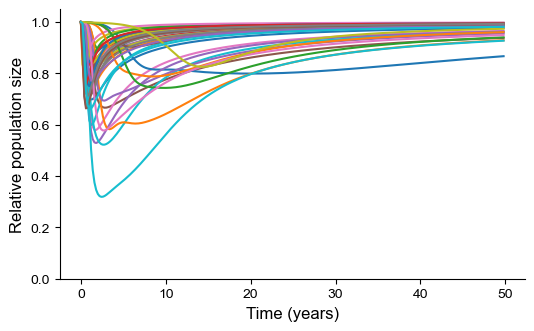

In [27]:
# Plot some trajectories
np.random.seed(120)
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
rand_inds = np.random.choice(np.arange(len(trajectories)), size=40)
for r in rand_inds:
    tres = trajectories[r]
    tind = tres.time < 50
    ax.plot(tres.time[tind], tres.N[tind] / tres.N[0])
ax.set_xlabel("Time (years)", size=12)
ax.set_ylabel("Relative population size", size=12)
ax.set_ylim(0, 1.05)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [12]:
# Compare recovery time for tolerant hosts
recov_time_compare_tolerance = time_full_recovery[good_inds] / time_full_recovery_no_pathogen[good_inds]

/var/folders/4k/1wymgyj119ldyv4w2nc7py400000gn/T/ipykernel_36202/2236728287.py:2: RuntimeWarning: divide by zero encountered in divide
  recov_time_compare_tolerance = time_full_recovery[good_inds] / time_full_recovery_no_pathogen[good_inds]


## Figure S1: Compare recovery times for against disease-free recovery times

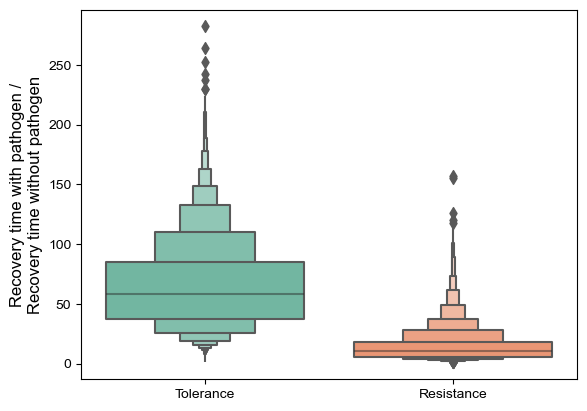

In [52]:
df_resist = pd.DataFrame({'defense': np.repeat("Resistance", len(recov_time_compare_resistance)), 
                          'ratio': recov_time_compare_resistance})
df_tolerance = pd.DataFrame({'defense': np.repeat("Tolerance", len(recov_time_compare_tolerance)), 
                              'ratio': recov_time_compare_tolerance})
df_all = pd.concat([df_resist, df_tolerance])
df_all = df_all[df_all.ratio != np.inf] # Drop infinities
ax = sns.boxenplot(x='defense', y='ratio', data=df_all, palette=["#66c2a5", "#fc8d62"], order=['Tolerance', 'Resistance'])
ax.set_ylabel("Recovery time with pathogen /\nRecovery time without pathogen", size=12)
ax.set_xlabel("")
plt.savefig("../results/disease_free_comparison.pdf", bbox_inches="tight")

## Question 2: How do recovery trajectories differ between host populations evolving tolerance or resistance defense strategies?

See the script `compare_resistance_and_tolerance_reduced_model.py` and `compare_resistance_and_tolerance_full_model.py`

## Question 3: How do trade-offs between host defense and fecundity alter the shape of host recovery trajectories?

### Trade-off in tolerance and fecundity

In [ ]:
from scipy.stats import qmc
import scipy.stats as stats
importlib.reload(eee)

# Set-up a latin hypercube simulation
samps = 500
plist = ['beta', 'lam', 'mu_z', 'r', 'mu', 'init_cv', 'init_alpha', 'alpha_m']
lower = [0.05, 100,  10,    0.1, 0.1,   0.05,   2, 0.1]
upper = [0.3,  1000, 100,   10,  3,    0.1,   4, 0.75]
sampler = qmc.LatinHypercube(d=len(lower))
sample = sampler.random(samps)
lhc_params = qmc.scale(sample, lower, upper)

# Predictors
parasiter_vals = []
parasiteR0_vals = []
hostr_vals = []
initial_cv = []
delta_vals = []

# Output
time_decline_stop = []
time_full_recovery = []
magnitude_of_decline = []
inds_used = []
trajectories = []

for s in range(samps):
    
    if (s + 1) % 10 == 0:
        print(s + 1)
    # Set parameters for simulation
    params = {}
    params['delta'] = 0.1
    for i, p in enumerate(plist):
        params[p] = lhc_params[s, i]
    params['alpha'] = params['init_alpha']
    
    # Set up initial values
    init_cv = params['init_cv']
    init_alpha = params['init_alpha']
    init_var = (init_cv*init_alpha)**2
    init_k = init_alpha**2 / init_var
    init_v = (init_alpha**2 / init_k) + init_alpha**2
    init_var = init_v - init_alpha**2 # init_alpha**2 / init_k #

    N_init = (params['r'] - params['mu']) / params['delta']
    parasiteR0 = (N_init*params['beta']*params['lam']) / ((params['init_alpha'] + params['mu'])*params['mu_z'])#max_eig(N_init, params)
    hostr = params['r'] - params['mu']

    if parasiteR0 > 1 and hostr > 0:
        parasiter = eee.max_eig(N_init, params)
        
        if parasiter > 0.01:

            time = np.linspace(0, 5000, num=25000)
            init_vals = np.array([N_init, N_init*0.001, 0, init_alpha, init_v])
            
            # Simulate model with tradeoff
            res = pd.DataFrame(odeint(eee.tolerance_model_tradeoff_approximation, init_vals, time, (params,)),
                               columns=['N', "I", 'Z', "alpha", "v"]).assign(time=time)
            
            # Get equilibrium
            equil = opt.fsolve(eee.moment_closure_model_tolerance_fecundity_tradeoff_equil, 
                               res.iloc[-1, :-1].values, args=(params,), xtol=1e-4)
            
            # Simulate baseline model with no tradeoff
            res_base = pd.DataFrame(odeint(eee.tolerance_model_no_tradeoff_approximation, init_vals, time, (params,)),
                                    columns=['N', "I", 'Z', "alpha", "v"]).assign(time=time)
            
            # Recovery to the SAME baseline
            recov = eee.recovery_metrics(res.N.values, time, percent=0.02, baseline=equil[0])
            recov_base = eee.recovery_metrics(res_base.N.values, time, percent=0.02, baseline=equil[0])
            
            magnitude_of_decline.append((recov[0], recov_base[0]))
            time_decline_stop.append((recov[1], recov_base[1]))
            time_full_recovery.append((recov[2], recov_base[2]))
            inds_used.append(s)
            parasiter_vals.append(parasiter)
            parasiteR0_vals.append(parasiteR0)
            hostr_vals.append(hostr)
            initial_cv.append(np.sqrt(init_var) / init_alpha)
            trajectories.append((res, res_base))

# convert to arrays
magnitude_of_decline = np.array(magnitude_of_decline)
time_decline_stop = np.array(time_decline_stop)
time_full_recovery = np.array(time_full_recovery)
inds_used = np.array(inds_used)
parasiter_vals = np.array(parasiter_vals)
parasiteR0_vals = np.array(parasiteR0_vals)
hostr_vals = np.array(hostr_vals)
initial_cv = np.array(initial_cv)

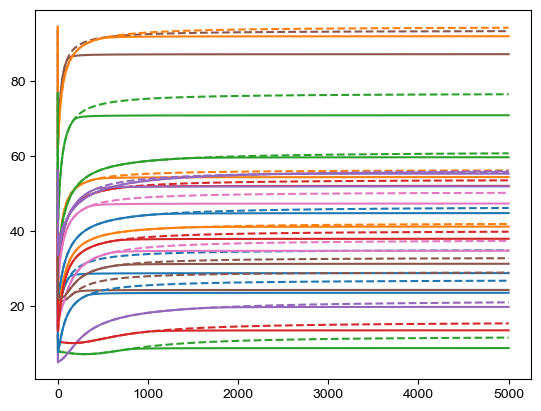

In [3]:
# Visualize some of the trajectories
for i in range(len(trajectories[:20])):
    
    j = i % 7
    res, res_base = trajectories[i]
    plt.plot(res.time, res.N, color=sns.color_palette()[j], ls="-")
    plt.plot(res_base.time, res_base.N, color=sns.color_palette()[j], ls="--")

In [6]:
from sklearn.preprocessing import scale
diff_stop = time_decline_stop[:, 0] / time_decline_stop[:, 1]
diff_mag = magnitude_of_decline[:, 0] /  magnitude_of_decline[:, 1]
diff_recovery = time_full_recovery[:, 0] / time_full_recovery[:, 1]

# Remove trajectories that haven't yet converged
tind = ((pd.Series(np.log10(diff_stop) > -1)) & 
         (pd.Series(time_decline_stop[:, 0]) < 500) & 
         (pd.Series(time_decline_stop[:, 1]) < 500)).values
diff_stop = diff_stop[tind]
diff_mag = diff_mag[tind]
diff_recovery = diff_recovery[tind]
trajectories_new = [trajectories[n] for n in np.where(tind)[0]]

dsets = [diff_stop, diff_recovery, diff_mag]
metric = ['Time until recovery\nbegins', "Time until recovery\nstops", "Magnitude of decline"]
comb = []
for i, d in enumerate(dsets):
    comb.append(pd.DataFrame(dict(metric=np.repeat(metric[i], len(d)),
                                  val=np.repeat("value", len(d)),
                                  diff=np.log10(d))))
comb_df = pd.concat(comb)

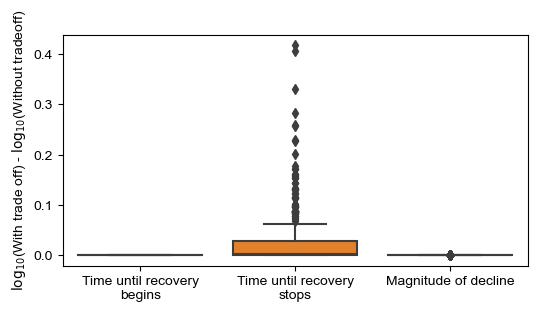

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax = sns.boxplot(x="metric", y="diff", data=comb_df, ax=ax)
ax.set_ylabel(r"$\log_{10}$(With trade off) - $\log_{10}$(Without tradeoff)")
ax.set_xlabel("")
fig.savefig("../results/tolerance_tradeoff_compare.pdf", bbox_inches="tight")

## Trade-off in resistance and fecundity

In [ ]:
from scipy.stats import qmc
import scipy.stats as stats
importlib.reload(eee)

# Set-up a latin hypercube simulation
samps = 500
plist = ['init_beta', 'lam', 'mu_z', 'r', 'mu', 'init_cv', 'alpha', 'beta_m']
lower = [0.1, 100,  10,    0.1, 0.1,   0.05,   2, 0.005]
upper = [0.3,  1000, 100,   10,  3,    0.1,   4, 0.05]
sampler = qmc.LatinHypercube(d=len(lower))
sample = sampler.random(samps)
lhc_params = qmc.scale(sample, lower, upper)

# Predictors
parasiter_vals = []
parasiteR0_vals = []
hostr_vals = []
initial_cv = []
delta_vals = []

# Output
time_decline_stop = []
time_full_recovery = []
magnitude_of_decline = []
inds_used = []
trajectories = []

for s in range(samps):
    
    if (s + 1) % 10 == 0:
        print(s + 1)
    # Set parameters for simulation
    params = {}
    params['delta'] = 0.1
    for i, p in enumerate(plist):
        params[p] = lhc_params[s, i]
    params['beta'] = params['init_beta']
    
    # Set up initial values
    init_cv = params['init_cv']
    init_beta = params['init_beta']
    init_var = (init_cv*init_beta)**2
    init_k = init_beta**2 / init_var
    init_v = (init_beta**2 / init_k) + init_beta**2
    init_var = init_v - init_beta**2 # init_alpha**2 / init_k #

    N_init = (params['r'] - params['mu']) / params['delta']
    parasiteR0 = (N_init*params['beta']*params['lam']) / ((params['alpha'] + params['mu'])*params['mu_z'])#max_eig(N_init, params)
    hostr = params['r'] - params['mu']

    if parasiteR0 > 1 and hostr > 0:
        parasiter = eee.max_eig(N_init, params)
        
        if parasiter > 0.01:

            time = np.linspace(0, 5000, num=25000)
            init_vals = np.array([N_init, N_init*0.001, 0, init_beta, init_beta, init_v, init_v])
            
            # Simulate model with tradeoff
            res = pd.DataFrame(odeint(eee.resistance_model_tradeoff, init_vals, time, (params,)),
                               columns=['N', "I", 'Z', "betaN", "betaI", "vN", "vI"]).assign(time=time)

            
            # Simulate baseline model with no tradeoff
            params2 = params.copy()
            params2['beta_m'] = 0
            res_base = pd.DataFrame(odeint(eee.resistance_model_tradeoff, init_vals, time, (params2,)),
                                    columns=['N', "I", 'Z', "betaN", "betaI", "vN", "vI"]).assign(time=time)
            
            # Recovery to the SAME baseline
            baseline = res.N.values[-1]
            recov = eee.recovery_metrics(res.N.values, time, percent=0.02, baseline=baseline, change_point=False)
            recov_base = eee.recovery_metrics(res_base.N.values, time, percent=0.02, baseline=baseline, change_point=False)
            
            magnitude_of_decline.append((recov[0], recov_base[0]))
            time_decline_stop.append((recov[1], recov_base[1]))
            time_full_recovery.append((recov[2], recov_base[2]))
            inds_used.append(s)
            parasiter_vals.append(parasiter)
            parasiteR0_vals.append(parasiteR0)
            hostr_vals.append(hostr)
            initial_cv.append(np.sqrt(init_var) / init_beta)
            trajectories.append((res, res_base))

# convert to arrays
magnitude_of_decline = np.array(magnitude_of_decline)
time_decline_stop = np.array(time_decline_stop)
time_full_recovery = np.array(time_full_recovery)
inds_used = np.array(inds_used)
parasiter_vals = np.array(parasiter_vals)
parasiteR0_vals = np.array(parasiteR0_vals)
hostr_vals = np.array(hostr_vals)
initial_cv = np.array(initial_cv)

In [10]:
from sklearn.preprocessing import scale
diff_stop = time_decline_stop[:, 0] / time_decline_stop[:, 1]
diff_mag = magnitude_of_decline[:, 0] /  magnitude_of_decline[:, 1]
diff_recovery = time_full_recovery[:, 0] / time_full_recovery[:, 1]

# Remove trajectories that haven't yet converged
tind = ((pd.Series(np.log10(diff_stop) > -1)) & 
         (pd.Series(time_decline_stop[:, 0]) < 500) & 
         (pd.Series(time_decline_stop[:, 1]) < 500)).values
diff_stop = diff_stop[tind]
diff_mag = diff_mag[tind]
diff_recovery = diff_recovery[tind]
trajectories_new = [trajectories[n] for n in np.where(tind)[0]]

dsets = [diff_stop, diff_recovery, diff_mag]
metric = ['Time until recovery\nbegins', "Time until recovery\nstops", "Magnitude of decline"]
comb = []
for i, d in enumerate(dsets):
    comb.append(pd.DataFrame(dict(metric=np.repeat(metric[i], len(d)),
                                  val=np.repeat("value", len(d)),
                                  diff=np.log10(d))))
comb_df = pd.concat(comb)

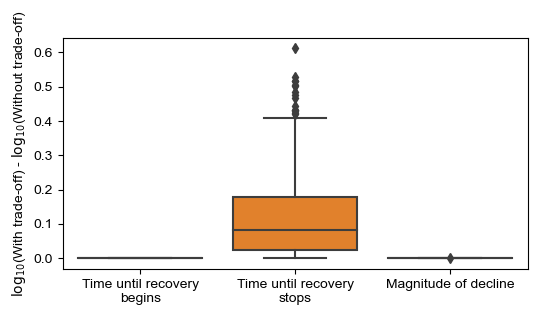

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax = sns.boxplot(x="metric", y="diff", data=comb_df, ax=ax)
ax.set_ylabel(r"$\log_{10}$(With trade-off) - $\log_{10}$(Without trade-off)")
ax.set_xlabel("")
fig.savefig("../results/resistance_tradeoff_compare.pdf", bbox_inches="tight")

## Plot trade-off curves, Fig. 5C and D

### Resistance, moment-closure model

In [211]:
%matplotlib inline

In [222]:
params = {'beta_m': 0.04,
         'lam': 843,
         'mu_z': 50,
         'r': 1.68,
         'mu': 0.56,
         'init_cv': 0.5,
         'alpha': 3.59,
         'delta': 0.14,
         'beta': 0.276}

init_cv = params['init_cv']
init_beta = params['beta']
init_var = (init_cv*init_beta)**2
init_k = init_beta**2 / init_var
init_v = (init_beta**2 / init_k) + init_beta**2
init_var = init_v - init_beta**2

N_init = (params['r'] - params['mu']) / params['delta']
parasiteR0 = (N_init*params['beta']*params['lam']) / ((params['alpha'] + params['mu'])*params['mu_z'])#max_eig(N_init, params)
hostr = params['r'] - params['mu']

time = np.linspace(0, 30, num=2500)
init_vals = np.array([N_init, N_init*0.001, 0, init_beta, init_beta, init_v, init_v])

res = pd.DataFrame(odeint(eee.resistance_model_tradeoff, init_vals, time, (params,)),
                   columns=['N', "I", 'Z', "betaN", "betaI", "vN", "vI"]).assign(time=time)

params2 = params.copy()
params2['beta_m'] = 0
res_base = pd.DataFrame(odeint(eee.resistance_model_tradeoff, init_vals, time, (params2,)),
                        columns=['N', "I", 'Z', "betaN", "betaI", "vN", "vI"]).assign(time=time)

Text(0, 0.5, 'Relative population size\nor prevalence')

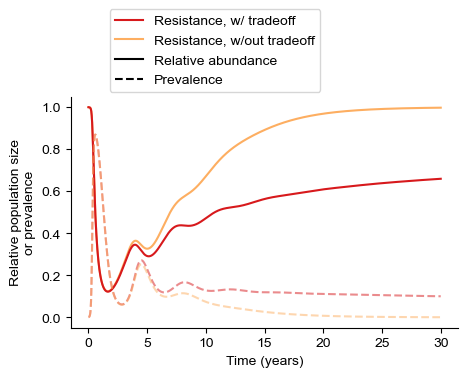

In [223]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

colors = ['#d7191c','#fdae61']
ax.plot(res_base.time, res_base.N / res_base.N[0], color=colors[1], label='Resistance, w/out tradeoff')
ax.plot(res.time, res.N / res.N[0], color=colors[0], label='Resistance, w/ tradeoff')

colors = ['#d7191c','#fdae61', 'black', 'black']
ls = ['-','-', '-', '--']
labels = ['Resistance, w/ tradeoff', 'Resistance, w/out tradeoff',
          'Relative abundance', 'Prevalence']
handles = [plt.Line2D([0], [0], color=colors[i], label=labels[i], linestyle=ls[i]) for i in range(4)]

ax.plot(res.time, res.I / res.N, color=colors[0], linestyle='--', alpha=0.5)
ax.plot(res_base.time, res_base.I / res_base.N, color=colors[1], linestyle='--', alpha=0.5)
ax.legend(handles=handles, loc=(0.1, 1.02))

ax.spines['right'].set_visible(None)
ax.spines['top'].set_visible(None)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Relative population size\nor prevalence")
#fig.savefig("../results/resistance_tradeoff.pdf", bbox_inches="tight")

### Resistance, full model with and without a tradeoff, Fig. S5

Simulate the same plots as above using the full model with and without a tradeoff

In [226]:
# Set bins for full model
params['bins'] = 200

# Set up the initial gamma distribution
init_var = (params['init_cv']*params['beta'])**2
theta = init_var / params['beta']
a = params['beta'] / theta
gamma_dist = stats.gamma(a, scale=theta)

# Set-up beta vals
beta_vals = np.linspace(0, 5, num=params['bins'])
Δ = beta_vals[1] - beta_vals[0]
probs = gamma_dist.cdf(beta_vals + Δ) - gamma_dist.cdf(beta_vals)
probs_norm = probs / np.sum(probs)
beta_vals_mid = beta_vals + Δ / 2
params['beta_vals'] = beta_vals_mid
params['r_vals'] = eee.r_fxn(beta_vals_mid, params['beta_m'], params['r'])

# Set-up the full model simulation
N_init = (params['r'] - params['mu']) / params['delta']
Nvals = probs_norm * N_init
Ivals = np.zeros(len(Nvals))
init_vals = np.concatenate([Nvals, Ivals, [1e-5]])

res = odeint(eee.full_resistance_model, init_vals, time, (params, ))
res_full_resist1 = (pd.DataFrame(odeint(eee.full_resistance_model, init_vals, time, (params, )))
                    .assign(time=time).set_index("time"))

# No tradeoff model
params2 = params.copy()
params2['beta_m'] = 0
params2['r_vals'] = eee.r_fxn(beta_vals_mid, params2['beta_m'], params2['r'])

res_full_resist2 = (pd.DataFrame(odeint(eee.full_resistance_model, init_vals, time, (params2, )))
                    .assign(time=time))

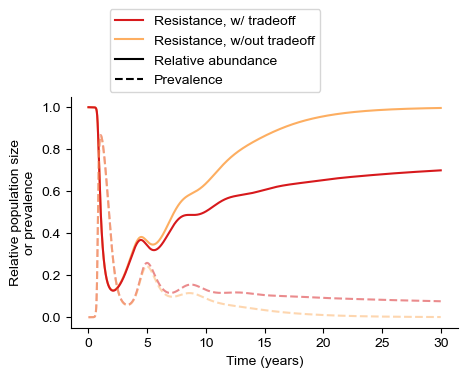

In [227]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

N_vals1 = res_full_resist1.iloc[:, :params['bins']].sum(axis=1)
N_vals2 = res_full_resist2.iloc[:, :params['bins']].sum(axis=1)
I_vals1 = res_full_resist1.iloc[:, params['bins']:(2*params['bins'])].sum(axis=1)
I_vals2 = res_full_resist2.iloc[:, params['bins']:(2*params['bins'])].sum(axis=1)

colors = ['#d7191c','#fdae61']
time = res_full_resist2.time.values
ax.plot(time, N_vals2 / N_vals2[0], color=colors[1], label='Resistance, w/out tradeoff')
ax.plot(time, N_vals1 / N_vals1[0], color=colors[0], label='Resistance, w/ tradeoff')

colors = ['#d7191c','#fdae61', 'black', 'black']
ls = ['-','-', '-', '--']
labels = ['Resistance, w/ tradeoff', 'Resistance, w/out tradeoff',
          'Relative abundance', 'Prevalence']
handles = [plt.Line2D([0], [0], color=colors[i], label=labels[i], linestyle=ls[i]) for i in range(4)]

ax.plot(time, I_vals1 / N_vals1, color=colors[0], linestyle='--', alpha=0.5)
ax.plot(time, I_vals2 / N_vals2, color=colors[1], linestyle='--', alpha=0.5)
ax.legend(handles=handles, loc=(0.1, 1.02))

ax.spines['right'].set_visible(None)
ax.spines['top'].set_visible(None)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Relative population size\nor prevalence")
fig.savefig("../results/resistance_tradeoff_full_model.pdf", bbox_inches="tight")

### Tolerance, reduced model

In [228]:
params = {'alpha_m': .1*3.59,
         'lam': 843,
         'mu_z': 50,
         'r': 1.68,
         'mu': 0.56,
         'init_cv': 0.5,
         'alpha': 3.59,
         'delta': 0.14,
         'beta': 0.276}

init_cv = params['init_cv']
init_alpha = params['alpha']
init_var = (init_cv*init_alpha)**2
init_k = init_alpha**2 / init_var
init_v = (init_alpha**2 / init_k) + init_alpha**2
init_var = init_v - init_alpha**2

N_init = (params['r'] - params['mu']) / params['delta']
parasiteR0 = (N_init*params['beta']*params['lam']) / ((params['alpha'] + params['mu'])*params['mu_z'])#max_eig(N_init, params)
hostr = params['r'] - params['mu']

time = np.linspace(0, 50, num=2500)
init_vals = np.array([N_init, N_init*0.001, 0, init_alpha, init_v])

res = pd.DataFrame(odeint(eee.tolerance_model_tradeoff_approximation, init_vals, time, (params,)),
                   columns=['N', "I", 'Z', "alphaN", "vN"]).assign(time=time)

params2 = params.copy()
params2['alpha_m'] = 0
res_base = pd.DataFrame(odeint(eee.tolerance_model_tradeoff_approximation, init_vals, time, (params2,)),
                   columns=['N', "I", 'Z', "alphaN", "vN"]).assign(time=time)

Text(0, 0.5, 'Relative population size\nor prevalence')

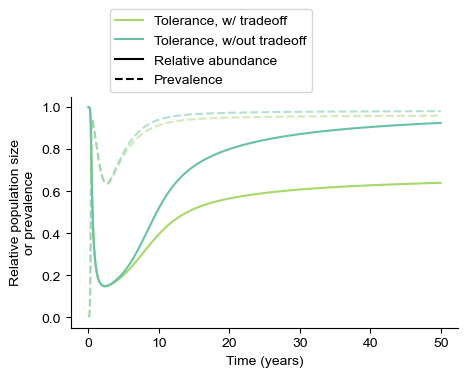

In [229]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

colors = ['#a6d96a', '#66c2a5', 'black', 'black']
ax.plot(res.time, res.N / res.N[0], color=colors[0])
ax.plot(res_base.time, res_base.N / res_base.N[0], color=colors[1])

ls = ['-','-', '-', '--']
labels = ['Tolerance, w/ tradeoff', 'Tolerance, w/out tradeoff',
          'Relative abundance', 'Prevalence']
handles = [plt.Line2D([0], [0], color=colors[i], label=labels[i], linestyle=ls[i]) for i in range(4)]

ax.plot(res.time, res.I / res.N, color=colors[0], linestyle='--', alpha=0.5)
ax.plot(res_base.time, res_base.I / res_base.N, color=colors[1], linestyle='--', alpha=0.5)
ax.legend(handles=handles, loc=(0.1, 1.02))

ax.spines['right'].set_visible(None)
ax.spines['top'].set_visible(None)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Relative population size\nor prevalence")
#fig.savefig("../results/tolerance_tradeoff.pdf", bbox_inches="tight")

### Tolerance, full model

Simulate the same plots as above with the full model with and without a tradeoff

In [235]:
# Set bins for full model
params['bins'] = 200

# Set up the initial gamma distribution
init_var = (params['init_cv']*params['alpha'])**2
theta = init_var / params['alpha']
a = params['alpha'] / theta
gamma_dist = stats.gamma(a, scale=theta)

# Set-up alpha vals
alpha_vals = np.linspace(0, 15, num=params['bins'])
Δ = alpha_vals[1] - alpha_vals[0]
probs = gamma_dist.cdf(alpha_vals + Δ) - gamma_dist.cdf(alpha_vals)
probs_norm = probs / np.sum(probs)
alpha_vals_mid = alpha_vals + Δ / 2
params['alpha_vals'] = alpha_vals_mid
params['r_vals'] = eee.r_fxn(alpha_vals_mid, params['alpha_m'], params['r'])

# Set-up the full model simulation
N_init = (params['r'] - params['mu']) / params['delta']
Nvals = probs_norm * N_init
Ivals = np.zeros(len(Nvals))
init_vals = np.concatenate([Nvals, Ivals, [1e-5]])

# Simulate with trade-off
res_full_tolerance1 = (pd.DataFrame(odeint(eee.full_tolerance_model, init_vals, time, (params, )))
                       .assign(time=time))

# Run the full model with no trade-off
params2 = params.copy()
params2['alpha_m'] = 0
params2['r_vals'] = eee.r_fxn(alpha_vals_mid, params2['alpha_m'], params2['r'])

res_full_tolerance2 = (pd.DataFrame(odeint(eee.full_tolerance_model, init_vals, time, (params2, )))
                      .assign(time=time))

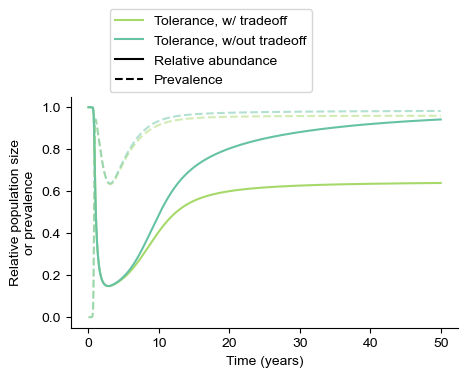

In [237]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

N_vals1 = res_full_tolerance1.iloc[:, :params['bins']].sum(axis=1)
N_vals2 = res_full_tolerance2.iloc[:, :params['bins']].sum(axis=1)
I_vals1 = res_full_tolerance1.iloc[:, params['bins']:(2*params['bins'])].sum(axis=1)
I_vals2 = res_full_tolerance2.iloc[:, params['bins']:(2*params['bins'])].sum(axis=1)

colors = ['#a6d96a', '#66c2a5', 'black', 'black']
time = res_full_tolerance1.time
ax.plot(time, N_vals1 / N_vals1[0], color=colors[0])
ax.plot(time, N_vals2 / N_vals2[0], color=colors[1])

ls = ['-','-', '-', '--']
labels = ['Tolerance, w/ tradeoff', 'Tolerance, w/out tradeoff',
          'Relative abundance', 'Prevalence']
handles = [plt.Line2D([0], [0], color=colors[i], label=labels[i], linestyle=ls[i]) for i in range(4)]

ax.plot(time, I_vals1 / N_vals1, color=colors[0], linestyle='--', alpha=0.5)
ax.plot(time, I_vals2 / N_vals2, color=colors[1], linestyle='--', alpha=0.5)
ax.legend(handles=handles, loc=(0.1, 1.02))

ax.spines['right'].set_visible(None)
ax.spines['top'].set_visible(None)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Relative population size\nor prevalence")
fig.savefig("../results/tolerance_tradeoff_full_model.pdf", bbox_inches="tight")

## Figure S5, S6: Maintenance of variation in resistance traits

Simulate a resistance model to demonstrate that variance in resistance can be maintained without a trade-off, but, if the pathogen persists and there is a trade-off between resistance and fecundity, resistance goes to fixation.

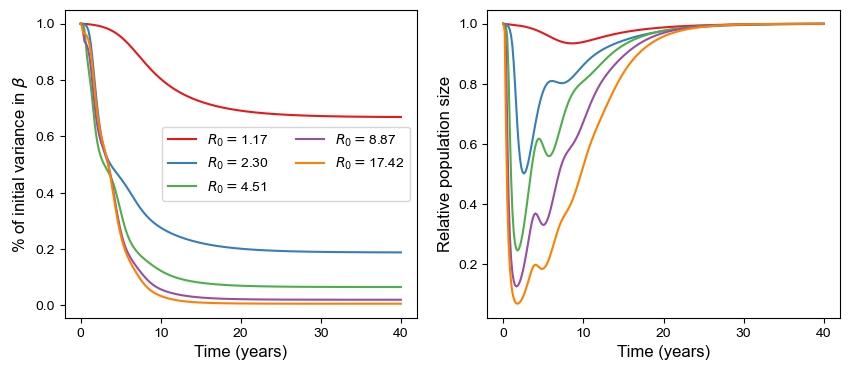

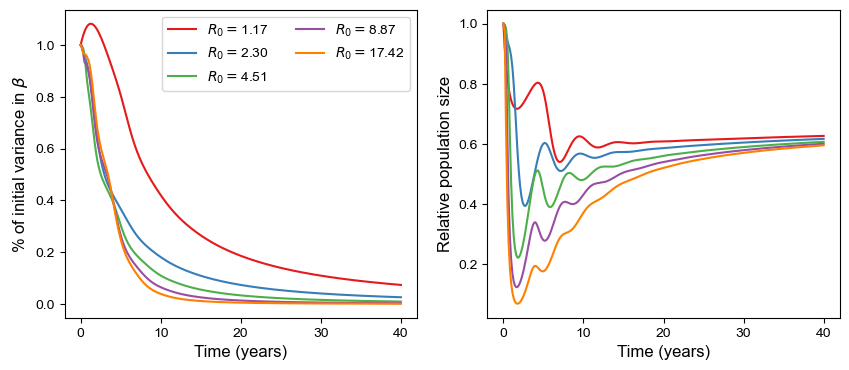

In [248]:
params = {'beta_m': 0.00,
         'lam': 843,
         'mu_z': 50,
         'r': 1.68,
         'mu': 0.56,
         'init_cv': 0.5,
         'alpha': 3.59,
         'delta': 0.14,
         'beta': 0.536}

beta_m_vals = [0, 0.05] # With a trade-off and without trade-off
file_names = ["maintenance_of_variation", "loss_of_variation"]

beta_vals = np.logspace(np.log10(0.036), np.log10(0.536), num=5)

for b, beta_m in enumerate(beta_m_vals):
    
    params['beta_m'] = beta_m
    trajs = []
    R0_vals = []
    init_vars = []
    for tbeta in beta_vals:

        params['beta'] = tbeta
        init_cv = params['init_cv']
        init_beta = params['beta']
        init_var = (init_cv*init_beta)**2
        init_k = init_beta**2 / init_var
        init_v = (init_beta**2 / init_k) + init_beta**2
        init_var = init_v - init_beta**2

        N_init = (params['r'] - params['mu']) / params['delta']
        parasiteR0 = (N_init*params['beta']*params['lam']) / ((params['alpha'] + params['mu'])*params['mu_z'])
        R0_vals.append(parasiteR0)
        hostr = params['r'] - params['mu']

        time = np.linspace(0, 40, num=250)
        init_vals = np.array([N_init, N_init*0.001, 0, init_beta, init_beta, init_v, init_v])

        res_base = (pd.DataFrame(odeint(eee.resistance_model_tradeoff, init_vals, time, (params,)),
                                columns=['N', "I", 'Z', "betaN", "betaI", "vN", "vI"])
                            .assign(time=time, variance=lambda x: x.vN - x.betaN**2))
        trajs.append(res_base)
        init_vars.append(init_var)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes = axes.ravel()

    colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']
    for i, tres in enumerate(trajs):
        axes[0].plot(tres.time, tres.variance / init_vars[i], color=colors[i], label=r"$R_0 = $" + "{0:.2f}".format(R0_vals[i]))
        axes[1].plot(tres.time, tres.N / tres.N.values[0], color=colors[i])

    axes[0].legend(ncol=2)
    size=12
    axes[0].set_ylabel(r"% of initial variance in $\beta$", size=size)
    axes[0].set_xlabel("Time (years)", size=size)
    axes[1].set_ylabel("Relative population size", size=size)
    axes[1].set_xlabel("Time (years)", size=size)
    #fig.savefig("../results/{0}.pdf".format(file_names[b]), bbox_inches="tight")

## Full model comparison

This section is for exploratory purposes such that users can explore the differences between the full models (and associated assumptions about number of bins and bin width) and the reduced models.

1. Chunk 1: Define parameters
2. Chunk 2: Run the full resistance model
3. Chunk 3: Run the reduced/moment-closure resistance model
4. Chunk 4: Run the full tolerance model
5. Chunk 5: Run the reduced/moment-closure tolerance model

In [263]:
## Full resistance model with bin approximation

# Params that can be manipulated
params = {'beta_m': 0,
          'alpha_m': 0,
         'lam': 543,
         'mu_z': 50,
         'r': 1.68,
         'mu': 1,
         'init_cv': 0.5,
         'alpha': 1,
         'delta': 0.14,
         'beta': 0.2}

In [264]:
## Full resistance model with bin approximation

params['bins'] = 500
time = np.linspace(0, 100, num=250)

# Set up the initial gamma distribution
init_var = (params['init_cv']*params['beta'])**2
theta = init_var / params['beta']
a = params['beta'] / theta
gamma_dist = stats.gamma(a, scale=theta)

# Set-up beta vals
beta_vals = np.linspace(0, 5, num=params['bins'])
Δ = beta_vals[1] - beta_vals[0]
probs = gamma_dist.cdf(beta_vals + Δ) - gamma_dist.cdf(beta_vals)
probs_norm = probs / np.sum(probs)
beta_vals_mid = beta_vals + Δ / 2
params['beta_vals'] = beta_vals_mid
params['r_vals'] = eee.r_fxn(beta_vals_mid, params['beta_m'], params['r'])

# Set-up the full model simulation
N_init = (params['r'] - params['mu']) / params['delta']
Nvals = probs_norm * N_init
Ivals = np.zeros(len(Nvals))
init_vals = np.concatenate([Nvals, Ivals, [1e-5]])

res = odeint(eee.full_resistance_model, init_vals, time, (params, ))
res_full_resist = pd.DataFrame(res).assign(time=time).set_index("time")

In [265]:
# Reduced/moment-closure resistance model

init_cv = params['init_cv']
init_beta = params['beta']
init_var = (init_cv*init_beta)**2
init_k = init_beta**2 / init_var
init_v = (init_beta**2 / init_k) + init_beta**2
init_var = init_v - init_beta**2

N_init = (params['r'] - params['mu']) / params['delta']
parasiteR0 = (N_init*params['beta']*params['lam']) / ((params['alpha'] + params['mu'])*params['mu_z'])
hostr = params['r'] - params['mu']

init_vals = np.array([N_init, 0.0000001, 1e-5, init_beta, init_beta, init_v, init_v])

res_red_resist = (pd.DataFrame(odeint(eee.resistance_model_tradeoff, init_vals, time, (params,)),
                        columns=['N', "I", 'Z', "betaN", "betaI", "vN", "vI"])
                    .assign(time=time, variance=lambda x: x.vN - x.betaN**2))

# Check parasite R0
parasiteR0

5.274857142857141

In [266]:
## Full tolerance model with bin approximation

# Set up the initial gamma distribution
init_var = (params['init_cv']*params['alpha'])**2
theta = init_var / params['alpha']
a = params['alpha'] / theta
gamma_dist = stats.gamma(a, scale=theta)

# Set-up alpha vals
alpha_vals = np.linspace(0, 10, num=params['bins'])
Δ = alpha_vals[1] - alpha_vals[0]
probs = gamma_dist.cdf(alpha_vals + Δ) - gamma_dist.cdf(alpha_vals)
probs_norm = probs / np.sum(probs)
alpha_vals_mid = alpha_vals + Δ / 2
params['alpha_vals'] = alpha_vals_mid
params['r_vals'] = eee.r_fxn(alpha_vals_mid, params['alpha_m'], params['r'])

# Set-up the full model simulation
N_init = (params['r'] - params['mu']) / params['delta']
Nvals = probs_norm * N_init
Ivals = np.zeros(len(Nvals))
init_vals = np.concatenate([Nvals, Ivals, [1e-5]])

res = odeint(eee.full_tolerance_model, init_vals, time, (params, ))
res_full_tolerance = pd.DataFrame(res).assign(time=time).set_index("time")

In [267]:
# Reduced/moment-closure tolerance model

init_cv = params['init_cv']
init_alpha = params['alpha']
init_var = (init_cv*init_alpha)**2
init_k = init_alpha**2 / init_var
init_v = (init_alpha**2 / init_k) + init_alpha**2
init_var = init_v - init_alpha**2

N_init = (params['r'] - params['mu']) / params['delta']
parasiteR0 = (N_init*params['beta']*params['lam']) / ((params['alpha'] + params['mu'])*params['mu_z'])
hostr = params['r'] - params['mu']

init_vals = np.array([N_init, 0.000001, 1e-5, init_alpha, init_v])

res_red_tolerance = (pd.DataFrame(odeint(eee.tolerance_model_tradeoff_approximation, init_vals, time, (params,)),
                        columns=['N', "I", 'Z', "alphaN", "vN"])
                    .assign(time=time, variance=lambda x: x.vN - x.alphaN**2))

### Compare output

Text(0.5, 0, 'Time (years)')

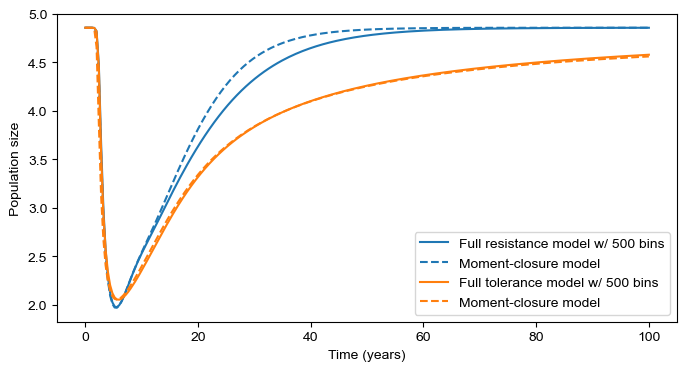

In [268]:
fig, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
axes = [axes]#axes.ravel()

# Plot resistance predictions
full_N_resist = res_full_resist.iloc[:, :params['bins']].sum(axis=1) # Extract N vals
axes[0].plot(full_N_resist.index, full_N_resist.values, 
             color=sns.color_palette()[0], ls='-', 
             label="Full resistance model w/ {0} bins".format(params['bins']))
axes[0].plot(res_red_resist.time, res_red_resist.N, 
             color=sns.color_palette()[0], ls='--', 
             label="Moment-closure model")

# Plot tolerance predictions
full_N_tolerance = res_full_tolerance.iloc[:, :params['bins']].sum(axis=1) # Extract N vals
axes[0].plot(full_N_tolerance.index, full_N_tolerance.values, 
             color=sns.color_palette()[1], ls='-', 
             label="Full tolerance model w/ {0} bins".format(params['bins']))
axes[0].plot(res_red_tolerance.time, res_red_tolerance.N, 
             color=sns.color_palette()[1], ls="--", 
             label="Moment-closure model")

axes[0].legend()
axes[0].set_ylabel("Population size")
axes[0].set_xlabel("Time (years)")

## Exploratory simulation: Multi-species model

One of the advantages of the $E^3$ framework is that it can also be used to explore recovery dynamics in ecological communities.  Note that we do not explore this in the associated manuscript, but here we provide code to facilitate explorations to facilitate exploration of community-level recovery and resilience.

### Explore a community-level model with both resistant and tolerant hosts

In [269]:
# Specify a three host community with 1 resistance host and two tolerant hosts
params = {'num_resistant': 1,
          'num_tolerant': 2,
          'mu': np.array([0.2, 0.56, 1]),
          'r': np.array([0.9, 1.68, 2]),
          'lam': np.array([843, 843, 843]),
          'mu_z': np.array([100])}

# Inter-specific interactions among species
params['delta'] = np.array([[0.14, 0, 0],
                            [0.08, 0.14, 0],
                            [0.08, 0, 0.14]])

params['init_cv'] = np.array([0.5, 0.5, 0.5])

# Resistant parameters...alpha is fixed
params['alpha'] = np.array([3.59])
params['beta_m'] = np.array([0.0])
params['init_beta'] = np.array([0.536])

# Tolerant parameters...beta is fixed
params['beta'] = np.array([0.536, 0.536])
params['alpha_m'] = np.array([0, 0.5])
params['init_alpha'] = np.array([3.59, 3.59])

# Set-up state variables for resistant hosts
resist_count = 0
tolerant_count = 0
all_init = []
colnames = []
baseN = (params['r'] - params['mu']) / np.diag(params['delta'])
equilN = opt.fsolve(eee.disease_free_equil, baseN, args=(params, ))

for i in np.arange(params['num_resistant'] + params['num_tolerant']):
    
    # Build state variables for resistant hosts
    if i < params['num_resistant']:
 
        init_cv = params['init_cv'][i]
        init_beta = params['init_beta'][resist_count]
        init_var = (init_cv*init_beta)**2
        init_k = init_beta**2 / init_var
        init_v = (init_beta**2 / init_k) + init_beta**2
        init_var = init_v - init_beta**2
        
        N_init = equilN[i]
        
        init_vals = [N_init, N_init*0.001, init_beta, init_beta, init_v, init_v]
        tcolnames = ["{0}{1}".format(let, i) for let in ["N", "I", "betaN", "betaI", "vN_beta", "vI_beta"]]
        colnames.append(tcolnames)
        all_init.append(init_vals)
        resist_count += 1
    
    # Build state variables for tolerant hosts
    else:
        
        init_cv = params['init_cv'][i]
        init_alpha = params['init_alpha'][tolerant_count]
        init_var = (init_cv*init_alpha)**2
        init_k = init_alpha**2 / init_var
        init_v = (init_alpha**2 / init_k) + init_alpha**2
        init_var = init_v - init_alpha**2
        
        N_init = equilN[i]
        init_vals = [N_init, N_init*0.001, init_alpha, init_v]
        tcolnames = ["{0}{1}".format(let, i) for let in ["N", "I", "alphaN", "vN_alpha"]]
        colnames.append(tcolnames)
        all_init.append(init_vals)
        tolerant_count += 1

all_init.append([0])
colnames.append(['Z'])
init_vals = np.concatenate(all_init)
colnames = np.concatenate(colnames)

In [270]:
## Simulate multi-species model
time = np.linspace(0, 60, num=1000)
res = odeint(eee.multispecies_epiecoevo, init_vals, time, (params, ))
res_df = pd.DataFrame(res, columns=colnames).assign(time=time).set_index("time")

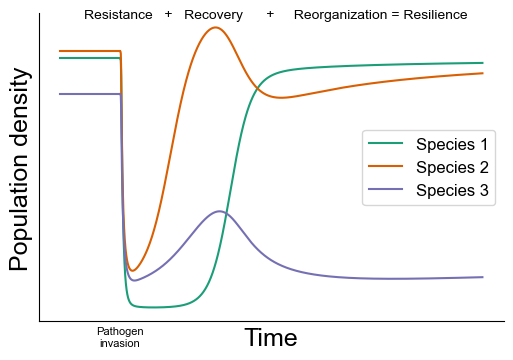

In [271]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
colors = ['#1b9e77','#d95f02','#7570b3']
Nvals = res_df.iloc[:, np.array([0, 6, 10])]
for i in range(Nvals.shape[1]):
    before = np.linspace(-10, 0)
    ax.plot(before, np.repeat(Nvals.iloc[0, i], len(before)), color=colors[i])
    ax.plot(Nvals.index, Nvals.iloc[:, i], color=colors[i], label="Species {0}".format(i + 1))

ax.set_ylabel("Population density", size=18)
ax.set_xlabel("Time", size=18)
ax.tick_params(labelleft=None, labelbottom=None, bottom=None, left=None)
ylim = ax.get_ylim()
ax.text(-6, 5.8, "Resistance   +   Recovery      +     Reorganization = Resilience")
ax.text(0, -0.75, "Pathogen\ninvasion", ha='center', size=8)
ax.legend(prop={'size': 12})
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#fig.savefig("../results/multispp_traj.jpg", dpi=250, bbox_inches="tight")

## Plot the community-level resilience trajectory though 3D space

In [272]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        return(np.min(zs))
        #FancyArrowPatch.draw(self, renderer)

/var/folders/4k/1wymgyj119ldyv4w2nc7py400000gn/T/ipykernel_5225/3903821418.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


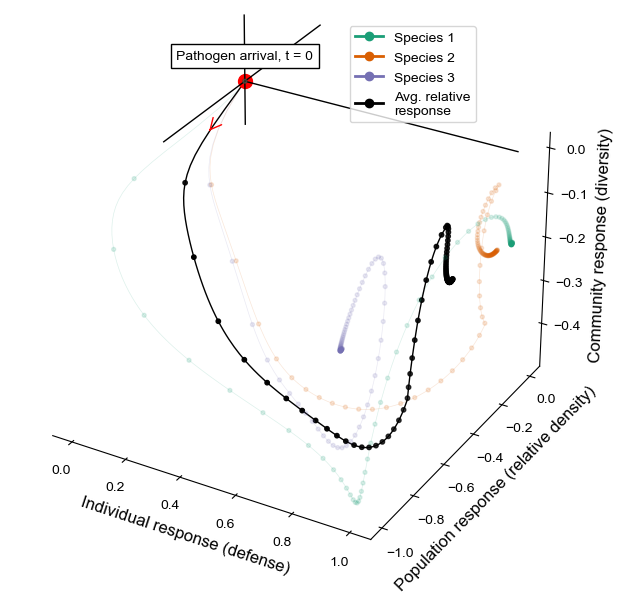

In [273]:
from mpl_toolkits import mplot3d
importlib.reload(eee)

# Calculate diversity
columns = ["N{0}".format(i) for i in np.arange(params['num_resistant'] + params['num_tolerant'])]
Nvals = res_df[columns]
defense_names = ["betaN"]*params['num_resistant'] + ["alphaN"]*params['num_tolerant']
H = [eee.shannon_diversity(Nvals.iloc[i]) for i in range(len(Nvals))]

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')


colors = ['#1b9e77','#d95f02','#7570b3']
xnorms = []
ynorms = []
znorms = []
for i in range(3):
    x = res_df.loc[:, '{0}{1}'.format(defense_names[i], i)].values
    xnorm = (1 - (x / x[0]))#*np.sign(x - x[0])
    y = res_df.loc[:, 'N{0}'.format(i)].values
    ynorm = (1 - (y / y[0]))*np.sign(y - y[0])
    z = H
    znorm = (1 - (z / z[0]))*np.sign(z - z[0])
    cbar = ax.scatter3D(xnorm[::10], ynorm[::10], znorm[::10], c=colors[i], s=8, alpha=0.15)
    ax.plot3D(xnorm, ynorm, znorm, colors[i], linewidth=0.5, alpha=0.15)
    xnorms.append(xnorm)
    ynorms.append(ynorm)
    znorms.append(znorm)

xavg = np.array(xnorms).mean(axis=0)
yavg = np.array(ynorms).mean(axis=0)    
zavg = np.array(znorms).mean(axis=0)
cbar = ax.scatter3D(xavg[::10], yavg[::10], zavg[::10], c='black', s=10)
line3d = ax.plot3D(xavg, yavg, zavg, 'black', linewidth=1)[0]

delta = 0.01
xst = xavg[5]
yst = yavg[5]
zst = zavg[5]
a = Arrow3D([xst, xst - delta], [yst, yst - delta], 
            [zst, zst - delta], mutation_scale=20, 
            lw=1, arrowstyle="->", color="red")
ax.add_artist(a)

    
ax.scatter3D([0], [0], [0], c='red', s=100)  
ax.text3D(0, 0, 0.05, "Pathogen arrival, t = 0", ha="center", 
            bbox={'facecolor': 'white', 'edgecolor':'black'}, zorder=10)
all_colors = colors + ['black']
labels = ["Species 1", "Species 2", 'Species 3', "Avg. relative\nresponse"]
handles = [plt.Line2D([0], [0], marker='o', color=all_colors[i], linestyle='-', lw=2, 
                      label=labels[i]) for i in range(4)]
ax.legend(handles=handles, loc=(0.6, 0.8))
ax.set_xlabel("Individual response (defense)", size=12)
ax.set_ylabel("Population response (relative density)", size=12)
ax.set_zlabel("Community response (diversity)", size=12)

# Make a 3D quiver plot
x, y, z = np.array([[0,0,0],[0,-0.5,0],[0,0,-0.1]])
u, v, w = np.array([[1,0,0],[0,1,0],[0,0,0.25]])
ax.quiver(x,y,z,u,v,w,arrow_length_ratio=0, color="black", linewidth=1)
ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.tight_layout()

Text(0, 0.5, 'Community response (rel. diversity)')

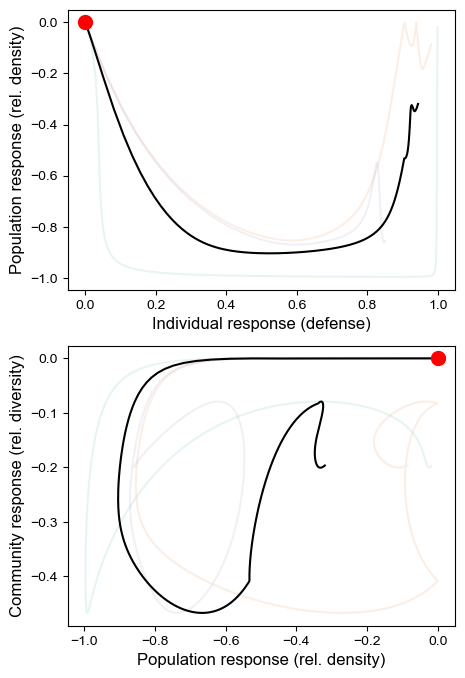

In [275]:
from mpl_toolkits import mplot3d
importlib.reload(eee)

# Calculate diversity
columns = ["N{0}".format(i) for i in np.arange(params['num_resistant'] + params['num_tolerant'])]
Nvals = res_df[columns]
defense_names = ["betaN"]*params['num_resistant'] + ["alphaN"]*params['num_tolerant']
H = [eee.shannon_diversity(Nvals.iloc[i]) for i in range(len(Nvals))]

fig, axes = plt.subplots(2, 1, figsize=(5, 8))
axes = axes.ravel()
#ax = plt.axes(projection='3d')


colors = ['#1b9e77','#d95f02','#7570b3']
xnorms = []
ynorms = []
znorms = []
for i in range(3):
    x = res_df.loc[:, '{0}{1}'.format(defense_names[i], i)].values
    xnorm = (1 - (x / x[0]))#*np.sign(x - x[0])
    y = res_df.loc[:, 'N{0}'.format(i)].values
    ynorm = (1 - (y / y[0]))*np.sign(y - y[0])
    z = H
    znorm = (1 - (z / z[0]))*np.sign(z - z[0])
    xnorms.append(xnorm)
    ynorms.append(ynorm)
    znorms.append(znorm)
    axes[0].plot(xnorm, ynorm, '-', color=colors[i], ms=5, alpha=0.1)
    axes[1].plot(ynorm, znorm, '-', color=colors[i], ms=5, alpha=0.1)

xavg = np.array(xnorms).mean(axis=0)
yavg = np.array(ynorms).mean(axis=0)    
zavg = np.array(znorms).mean(axis=0)
line1 = axes[0].plot(xavg, yavg, '-', color='black', ms=5)
line2 = axes[1].plot(yavg, zavg, '-', color='black', ms=5)
axes[0].plot([0], [0], 'o', color='red', ms=10)
axes[1].plot([0], [0], 'o', color='red', ms=10)
#add_arrow(line1[0], position=xavg[5], color="red")
#add_arrow(line2[0], position=yavg[5], color="red")

s = 12
axes[0].set_xlabel("Individual response (defense)", size=s)
axes[0].set_ylabel("Population response (rel. density)", size=s)
axes[1].set_xlabel("Population response (rel. density)", size=s)
axes[1].set_ylabel("Community response (rel. diversity)", size=s)